#### In this notebook we take the manually segmented aorta's and do the pre-processing before putting them into a h5 file


Go to python file bern_numpy_to_hdf5.py for the whole of the numpy files being put into a h5 for inference (this is done in the data folder where each of the patients is converted to a h5 file )

In [1]:
import os
import h5py

from utils import crop_or_pad_Bern_slices, normalize_image, make_dir_safely,crop_or_pad_Bern_all_slices
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# The dataset from Freiburg had an input size of [144, 112,32,48]

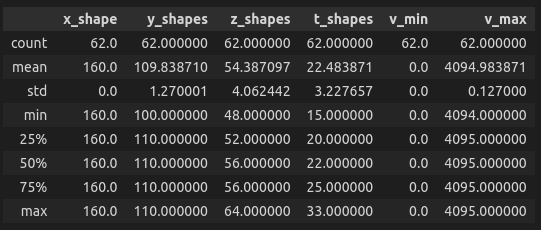

In [3]:
path_bern_seg = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/segmenter_rw_pw_hard/controls"
path_bern_img = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy"
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
os.listdir(path_bern_seg)


['seg_MACDAVD_101_.npy',
 'seg_MACDAVD_102_.npy',
 'seg_MACDAVD_103_.npy',
 'seg_MACDAVD_104_.npy',
 'seg_MACDAVD_105_.npy',
 'seg_MACDAVD_106_.npy',
 'seg_MACDAVD_109_.npy',
 'seg_MACDAVD_110_.npy',
 'seg_MACDAVD_116_.npy',
 'seg_MACDAVD_117_.npy',
 'seg_MACDAVD_118_.npy',
 'seg_MACDAVD_119_.npy',
 'seg_MACDAVD_120_.npy',
 'seg_MACDAVD_122_.npy',
 'seg_MACDAVD_124_.npy',
 'seg_MACDAVD_126_.npy',
 'seg_MACDAVD_127_.npy',
 'seg_MACDAVD_129_.npy',
 'seg_MACDAVD_132_.npy',
 'seg_MACDAVD_134_.npy',
 'seg_MACDAVD_135_.npy',
 'seg_MACDAVD_137_.npy',
 'seg_MACDAVD_142_.npy',
 'seg_MACDAVD_145_.npy',
 'seg_MACDAVD_146_.npy',
 'seg_MACDAVD_148_.npy',
 'seg_MACDAVD_152_.npy']

In [4]:
len(os.listdir(path_bern_seg))

27

In [5]:
len(os.listdir(path_bern_seg))

27

In [6]:
# When not cut
patients_indexes_not_cut = [0, 55,115, 167, 223,271, 327]
train_indexes_not_cut = [0, 55,115, 167, 223]
val_indexes_bot_cut = [0, 47,104]

In [7]:
# When cut
patients_indexes = [0, 49,103, 149, 199,241, 327]
train_indexes = [0, 49,103,149, 199]
val_indexes = [0, 41,91]

In [8]:
try:
    debug_in = np.load(path_bern_img + "/MACDAVD_104_.npy")
    debug_label = np.load(path_bern_seg + "/seg_MACDAVD_104_.npy")
    #slice_ = 0
    print(slice_)
    %matplotlib inline
    plt.imshow(debug_in[:, :,slice_, 3,1])
    #plt.show()
    plt.imshow(debug_in[:, :,slice_, 3,1])
    plt.imshow(debug_label[:, :,slice_, 3], alpha= 0.1)
    slice_ +=1 
    plt.show()
except:
    pass

In [9]:
np.arange(21)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [10]:
# This is when using an arbitrary number of slices
def prepare_and_write_data_bern_slices(basepath,
                           filepath_output,
                           idx_start,
                            idx_end,
                           train_test, z_slices = 40):
        
    # ==========================================
    # Study the the variation in the sizes along various dimensions (using the function 'find_shapes'), 
    # Using this knowledge, let us set common shapes for all subjects.
    # ==========================================
    # This shape must be the same in the file where all the training parameters are set!
    # Update: We keep all the Bern data and leave the batch dimension open to their original size
    # ==========================================
    common_image_shape = [144, 112, z_slices, 48, 4] # [x, y, t, num_channels]
    common_label_shape = [144, 112, z_slices, 48] # [x, y,t]
    # for x and y axes, we can remove zeros from the sides such that the dimensions are divisible by 16
    # (not required, but this makes it nice while training CNNs)
    
    # ==========================================
    # ==========================================
    seg_path = basepath + '/segmenter_rw_pw_hard/controls'
    img_path = basepath + '/preprocessed/controls/numpy'
    #num_images_to_load = idx_end + 1 - idx_start
    patients = os.listdir(seg_path)[idx_start:idx_end]
    num_images_to_load = len(patients)
    
    
    # ==========================================
    # we will stack all images along their z-axis
    # --> the network will analyze (x,y,t) volumes, with z-samples being treated independently.
    # ==========================================
    images_dataset_shape = [common_image_shape[2]*num_images_to_load,
                            common_image_shape[0],
                            common_image_shape[1],
                            common_image_shape[3],
                            common_image_shape[4]]
    
    labels_dataset_shape = [common_label_shape[2]*num_images_to_load,
                            common_label_shape[0],
                            common_label_shape[1],
                            common_label_shape[3]]  
        
    # ==========================================
    # create a hdf5 file
    # ==========================================
    dataset = {}
    hdf5_file = h5py.File(filepath_output, "w") 
    
    # ==========================================
    # write each subject's image and label data in the hdf5 file
    # ==========================================    
    dataset['images_%s' % train_test] = hdf5_file.create_dataset("images_%s" % train_test, images_dataset_shape, dtype='float32')       
    dataset['labels_%s' % train_test] = hdf5_file.create_dataset("labels_%s" % train_test, labels_dataset_shape, dtype='uint8')       
    print('shape of the hdf5 dataset for images: ' + str(images_dataset_shape))
    print('common image shape: ' + str(common_image_shape))
    i = 0
    for patient in patients: 

        
        
        #print('loading subject ' + str(n-idx_start+1) + ' out of ' + str(num_images_to_load) + '...')
        print('loading subject ' + str(i) + ' out of ' + str(num_images_to_load) + '...')
        
        
        
        # load the numpy image (saved by the dicom2numpy file)
        image_data = np.load(os.path.join(img_path, patient.replace("seg_", "")))
        # normalize the image
        image_data = normalize_image(image_data)
        # make all images of the same shape
        image_data = crop_or_pad_Bern_slices(image_data, common_image_shape)
        # move the z-axis to the front, as we want to concantenate data along this axis
        image_data = np.moveaxis(image_data, 2, 0)                         
        # add the image to the hdf5 file
        dataset['images_%s' % train_test][i*common_image_shape[2]:(i+1)*common_image_shape[2], :, :, :, :] = image_data
    
        # load the numpy label (saved by the random walker segmenter)
        label_data = np.load(os.path.join(path_bern_seg, patient))
        # make all images of the same shape
        label_data = crop_or_pad_Bern_slices(label_data, common_label_shape)                  
        # move the z-axis to the front, as we want to concantenate data along this axis
        label_data = np.moveaxis(label_data, 2, 0)  
        # cast labels as uints
        label_data = label_data.astype(np.uint8)                       
        # add the image to the hdf5 file
        dataset['labels_%s' % train_test][i*common_label_shape[2]:(i+1)*common_label_shape[2], :, :, :] = label_data
        
        # increment the index being used to write in the hdf5 datasets
        i = i + 1
    
    # ==========================================
    # close the hdf5 file
    # ==========================================
    hdf5_file.close()

    return 0


In [11]:
# This is when using all slices
def prepare_and_write_data_bern_append(basepath,
                                       idx_start,
                                        idx_end,
                           filepath_output,
                           train_test):
        
    # ==========================================
    # Study the the variation in the sizes along various dimensions (using the function 'find_shapes'), 
    # Using this knowledge, let us set common shapes for all subjects.
    # ==========================================
    # This shape must be the same in the file where all the training parameters are set!
    # Update: We keep all the Bern data and leave the batch dimension open to their original size
    # ==========================================
    common_image_shape = [144, 112, None, 48, 4] # [x, y, t, num_channels]
    common_label_shape = [144, 112, None, 48] # [x, y,t]
    # for x and y axes, we can remove zeros from the sides such that the dimensions are divisible by 16
    # (not required, but this makes it nice while training CNNs)
    
    # ==========================================
    # ==========================================
    seg_path = basepath + '/segmenter_rw_pw_hard/controls'
    img_path = basepath + '/preprocessed/controls/numpy'
    #num_images_to_load = idx_end + 1 - idx_start
    """
    if train_test == 'train':
        patients = os.listdir(seg_path)[:4]
        num_images_to_load = len(patients)
    elif train_test == 'validation':
        patients = os.listdir(seg_path)[4:]
        num_images_to_load = len(patients)
    """

    patients = os.listdir(seg_path)[idx_start:idx_end]
    num_images_to_load = len(patients)
    # ==========================================
    # we will stack all images along their z-axis
    # --> the network will analyze (x,y,t) volumes, with z-samples being treated independently.
    # ==========================================
    images_dataset_shape = [None,
                            common_image_shape[0],
                            common_image_shape[1],
                            common_image_shape[3],
                            common_image_shape[4]]
    
    labels_dataset_shape = [None,
                            common_label_shape[0],
                            common_label_shape[1],
                            common_label_shape[3]]  
        
    # ==========================================
    # create a hdf5 file
    # ==========================================
    dataset = {}
    hdf5_file = h5py.File(filepath_output, "a") 
    
    # ==========================================
    # write each subject's image and label data in the hdf5 file
    # ==========================================    
      
    dataset['images_%s' % train_test] = hdf5_file.create_dataset('images_%s' % train_test, shape= (0, common_image_shape[0], common_image_shape[1], common_image_shape[3], common_image_shape[4]), maxshape=(None, common_image_shape[0], common_image_shape[1], common_image_shape[3], common_image_shape[4]), dtype='float32')
    dataset['alias'] = hdf5_file.create_dataset('alias', shape= (0,), maxshape=(None,), dtype='uint8')
    
    dataset['labels_%s' % train_test] = hdf5_file.create_dataset('labels_%s' % train_test, shape= (0, common_image_shape[0], common_image_shape[1], common_image_shape[3]), maxshape=(None, common_image_shape[0], common_image_shape[1], common_image_shape[3]), dtype='uint8')
    
    i = 0
    for patient in patients: 
                
        
        #print('loading subject ' + str(n-idx_start+1) + ' out of ' + str(num_images_to_load) + '...')
        print('loading subject ' + str(i) + ' out of ' + str(num_images_to_load) + '...')
        print(patient)
        
        
        
        # load the numpy image (saved by the dicom2numpy file)
        image_data = np.load(os.path.join(img_path, patient.replace("seg_", "")))
        # normalize the image
        image_data = normalize_image(image_data)
        # make all images of the same shape
        image_data = crop_or_pad_Bern_all_slices(image_data, common_image_shape)
        #image_data = crop_or_pad_Bern_slices(image_data, common_image_shape)

        # move the z-axis to the front, as we want to concantenate data along this axis
        image_data = np.moveaxis(image_data, 2, 0)                         
        
    
        # load the numpy label (saved by the random walker segmenter)
        label_data = np.load(os.path.join(path_bern_seg, patient))
        print(label_data)
        # make all images of the same shape
        label_data = crop_or_pad_Bern_all_slices(label_data, common_label_shape)                  
        #label_data = crop_or_pad_Bern_slices(label_data, common_label_shape)                  
        
        # move the z-axis to the front, as we want to concantenate data along this axis
        label_data = np.moveaxis(label_data, 2, 0)  
        # cast labels as uints
        label_data = label_data.astype(np.uint8)                       
        # add the image to the hdf5 file
        #dataset['labels_%s' % train_test] = label_data
        
        


        index_w_labels = np.where(label_data.sum(axis = (1,2,3)) >0)[0]
        label_data = label_data[index_w_labels]
        print(label_data.shape)
        print(image_data.shape)
        dataset['labels_%s' % train_test].resize(dataset['labels_%s' % train_test].shape[0] +label_data.shape[0], axis=0)
        dataset['labels_%s' % train_test][-label_data.shape[0]:] = label_data

        # add the image to the hdf5 file
        dataset['images_%s' % train_test].resize(dataset['images_%s' % train_test].shape[0] +label_data.shape[0], axis=0)    
        dataset['images_%s' % train_test][-label_data.shape[0]:] = image_data[index_w_labels]
        #dataset['images_%s' % train_test][-image_data.shape[0]:] = image_data
        
        # add the alias to the hdf5 file
        dataset['alias'].resize(dataset['alias'].shape[0] +label_data.shape[0], axis=0)
        alias = np.ones(image_data.shape[0])
        alias[3:-3] = 0
        dataset['alias'][-label_data.shape[0]:] = alias[index_w_labels]
        #dataset['alias'][-image_data.shape[0]:] = alias

        # increment the index being used to write in the hdf5 datasets
        i = i + 1
    
    # ==========================================
    # close the hdf5 file
    # ==========================================
    hdf5_file.close()

    return 0


In [13]:
# all slices
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
filepath_output = basepath + '/only_w_labels_bern_images_and_labels_from_101_to_121.hdf5'
prepare_and_write_data_bern_append(basepath,0,21,filepath_output,"train")

loading subject 0 out of 21...
seg_MACDAVD_101_.npy
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ..

0

In [14]:
# all slices
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
filepath_output = basepath + '/only_w_labels_bern_images_and_labels_from_122_to_127.hdf5'
prepare_and_write_data_bern_append(basepath,22,27,filepath_output,"validation")

loading subject 0 out of 5...
seg_MACDAVD_142_.npy
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...

0

In [ ]:
# all slices
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
filepath_output = basepath + '/bern_images_and_labels_from_101_to_127.hdf5'
prepare_and_write_data_bern_append(basepath,0,27,filepath_output,"train")

In [ ]:
# all slices
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
filepath_output = basepath + '/2000_pix_labels_bern_images_and_labels_from_101_to_106.hdf5'
prepare_and_write_data_bern_append(basepath,filepath_output,"train")

In [ ]:
filepath_output = basepath + '/bern_images_and_labels_from_105_to_106.hdf5'
prepare_and_write_data_bern_append(basepath,filepath_output,"validation")

In [14]:
672/32

21.0

In [16]:
# 40 slices
# change number of slices
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
filepath_output = basepath + '/size_32_bern_images_and_labels_from_101_to_121.hdf5'
prepare_and_write_data_bern_slices(basepath = basepath,filepath_output = filepath_output, idx_start =0, idx_end = 21,train_test = "train", z_slices = 32)

shape of the hdf5 dataset for images: [672, 144, 112, 48, 4]
common image shape: [144, 112, 32, 48, 4]
loading subject 0 out of 21...
loading subject 1 out of 21...
loading subject 2 out of 21...
loading subject 3 out of 21...
loading subject 4 out of 21...
loading subject 5 out of 21...
loading subject 6 out of 21...
loading subject 7 out of 21...
loading subject 8 out of 21...
loading subject 9 out of 21...
loading subject 10 out of 21...
loading subject 11 out of 21...
loading subject 12 out of 21...
loading subject 13 out of 21...
loading subject 14 out of 21...
loading subject 15 out of 21...
loading subject 16 out of 21...
loading subject 17 out of 21...
loading subject 18 out of 21...
loading subject 19 out of 21...
loading subject 20 out of 21...


0

In [18]:
# 40 slices
# Change number of slices
filepath_output = basepath + '/size_32_bern_images_and_labels_from_122_to_127.hdf5'
prepare_and_write_data_bern_slices(basepath = basepath,filepath_output = filepath_output, idx_start =22, idx_end = 27,train_test = "validation", z_slices = 32)

shape of the hdf5 dataset for images: [160, 144, 112, 48, 4]
common image shape: [144, 112, 32, 48, 4]
loading subject 0 out of 5...
loading subject 1 out of 5...
loading subject 2 out of 5...
loading subject 3 out of 5...
loading subject 4 out of 5...


0

In [15]:
basepath = "/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
#bern_tr = h5py.File(basepath + '/size_40_bern_images_and_labels_from_101_to_121.hdf5','r')
#bern_vl = h5py.File(basepath + '/size_40_bern_images_and_labels_from_122_to_127.hdf5','r')
#bern_tr = h5py.File(basepath + '/size_32_bern_images_and_labels_from_101_to_121.hdf5','r')
#bern_vl = h5py.File(basepath + '/size_32_bern_images_and_labels_from_122_to_127.hdf5','r')
bern_tr = h5py.File(basepath + '/only_w_labels_bern_images_and_labels_from_101_to_121.hdf5','r')
bern_vl = h5py.File(basepath + '/only_w_labels_bern_images_and_labels_from_122_to_127.hdf5','r')

In [16]:
bern_tr["images_train"].shape, bern_tr["labels_train"].shape, bern_vl["images_validation"].shape, bern_vl["labels_validation"].shape

((526, 144, 112, 48, 4),
 (526, 144, 112, 48),
 (100, 144, 112, 48, 4),
 (100, 144, 112, 48))

0


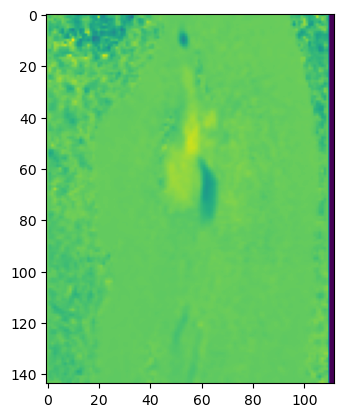

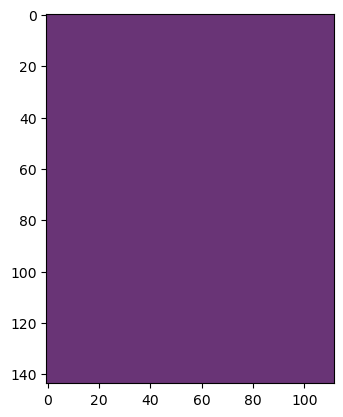

In [19]:
try:
    debug_in = bern_vl["images_validation"]
    debug_label = bern_vl["labels_validation"]
    slice_ = 0
    print(slice_)
    %matplotlib inline
    #plt.imshow(debug_in[slice_,:, :, 3,1])
    #plt.show()
    plt.imshow(debug_in[slice_,:, :, 3,1])
    plt.show()
    plt.imshow(debug_label[slice_,:, :, 3], alpha= 0.8)
    slice_ +=1 
    plt.show()
except:
    pass